## mol_rnn model (logP) -- keras

In [2]:
import numpy as np
from Teemo.algorithm.cntk.examples.mol_rnn import mol2ctf
from Teemo.utils import fileops

In [3]:
import getpass
import os
data_dir = '/home/'+getpass.getuser()+'/git_test/test_data/examples/logP/alogps/'
smiles_file = data_dir + 'alogps.smi'
logP_file = data_dir + 'alogps.logP'
assert os.path.exists(smiles_file), os.path.exists(logP_file)

num_mols = 100
smiles_data = [x[0] for x in fileops.read_file(smiles_file)][:num_mols]
logP_data = [x[0] for x in fileops.read_file(logP_file)][:num_mols]
def gen_mol_chain_data(smiles_data):
    mol_chain_data = []
    max_atoms_count = 0
    for sm in smiles_data:
        mol_chain = mol2ctf.one_smiles(sm)['mol_chain']
        mol_chain_data.append(mol_chain)
        atoms_count = len(mol_chain)
        if max_atoms_count < atoms_count:
            max_atoms_count = atoms_count
    print ('max_atoms_count: {0}'.format(max_atoms_count))
    return mol_chain_data

def gen_mol_values_sparse(mol_chain_data, logP, max_seq_length=100):
    assert len(mol_chain_data) == len(logP)
    sequences = []
    targets = []
    for one_mol, tg in zip(mol_chain_data, logP):
        for it in one_mol.values():
            values = it['chain_values']
            values += [0] * (max_seq_length - len(values))
            sequences.append(values)
            targets.append(tg)
    sequences = [np.asarray(x) for x in sequences]
    targets = [np.float(x) for x in targets]
   
    sequences = np.vstack(sequences)
    targets = np.asarray(targets)
    print ('sequences.shape: {0}, targets.shape: {1}'.format(sequences.shape, targets.shape))
    return sequences, targets
    
    
mol_chain_data = gen_mol_chain_data(smiles_data)
print (mol_chain_data[0])
sequences, targets = gen_mol_values_sparse(mol_chain_data, logP_data)

max_atoms_count: 18
{'C2': {'chain_values': [7, 18, 8, 24, 6, 18], 'chain_symbols': [['None_N3', 'N3'], ['C1_N3', 'C1'], ['None_O0', 'O0'], ['C1_O0', 'C1'], ['None_C1', 'C1'], ['C1_C2', 'C2']]}, 'C1': {'chain_values': [6, 18, 7, 18, 8, 24], 'chain_symbols': [['None_C2', 'C2'], ['C1_C2', 'C1'], ['None_N3', 'N3'], ['C1_N3', 'C1'], ['None_O0', 'O0'], ['C1_O0', 'C1']]}, 'N3': {'chain_values': [6, 18, 8, 24, 6, 21], 'chain_symbols': [['None_C2', 'C2'], ['C1_C2', 'C1'], ['None_O0', 'O0'], ['C1_O0', 'C1'], ['None_C1', 'C1'], ['C1_N3', 'N3']]}, 'O0': {'chain_values': [6, 18, 7, 18, 6, 32], 'chain_symbols': [['None_C2', 'C2'], ['C1_C2', 'C1'], ['None_N3', 'N3'], ['C1_N3', 'C1'], ['None_C1', 'C1'], ['C1_O0', 'O0']]}}
sequences.shape: (747, 100), targets.shape: (747,)


### prepare model

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, LSTM

Using Theano backend.


In [7]:
voca_size = 2300
emb_dim = 200
lstm_hidden_dim = 200
output_dim = 1
model = Sequential()
## mask_zeros: refer to https://github.com/fchollet/keras/blob/master/keras/layers/embeddings.py
model.add(Embedding(output_dim = emb_dim, input_dim = voca_size, mask_zero=True))
model.add(LSTM(output_dim=lstm_hidden_dim, return_sequences=False))
model.add(Dense(output_dim=1))
model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['mean_absolute_error'])

model.fit(sequences, targets, nb_epoch=10, batch_size=32)

from Teemo.algorithm.utils.evaluations import correlation_pearson
output = model.predict(sequences)[:, 0]
corr = correlation_pearson(output, targets)
print ('correlation pearson: {0}'.format(corr))

Epoch 1/10
747/747 [==============================] - 3s - loss: 1.5810 - mean_absolute_error: 1.0272     
Epoch 2/10
747/747 [==============================] - 3s - loss: 1.4450 - mean_absolute_error: 0.9924     
Epoch 3/10
747/747 [==============================] - 3s - loss: 1.3013 - mean_absolute_error: 0.9505     
Epoch 4/10
747/747 [==============================] - 3s - loss: 1.1663 - mean_absolute_error: 0.9071     
Epoch 5/10
747/747 [==============================] - 3s - loss: 1.0540 - mean_absolute_error: 0.8580     
Epoch 6/10
747/747 [==============================] - 3s - loss: 0.9348 - mean_absolute_error: 0.8067     
Epoch 7/10
747/747 [==============================] - 3s - loss: 0.8452 - mean_absolute_error: 0.7687     
Epoch 8/10
747/747 [==============================] - 3s - loss: 0.7486 - mean_absolute_error: 0.7081     
Epoch 9/10
747/747 [==============================] - 3s - loss: 0.7041 - mean_absolute_error: 0.6795     
Epoch 10/10
747/747 [================

In [10]:
model.fit(sequences, targets, nb_epoch=10, batch_size=32)
output = model.predict(sequences)[:, 0]
corr = correlation_pearson(output, targets)
print ('correlation pearson: {0}'.format(corr))

Epoch 1/10
747/747 [==============================] - 3s - loss: 0.5983 - mean_absolute_error: 0.5946     
Epoch 2/10
747/747 [==============================] - 3s - loss: 0.5692 - mean_absolute_error: 0.5913     
Epoch 3/10
747/747 [==============================] - 3s - loss: 0.5680 - mean_absolute_error: 0.5828     
Epoch 4/10
747/747 [==============================] - 3s - loss: 0.5617 - mean_absolute_error: 0.5860     
Epoch 5/10
747/747 [==============================] - 3s - loss: 0.5506 - mean_absolute_error: 0.5702     
Epoch 6/10
747/747 [==============================] - 4s - loss: 0.5502 - mean_absolute_error: 0.5776     
Epoch 7/10
747/747 [==============================] - 3s - loss: 0.5422 - mean_absolute_error: 0.5710     
Epoch 8/10
747/747 [==============================] - 3s - loss: 0.5220 - mean_absolute_error: 0.5580     
Epoch 9/10
747/747 [==============================] - 3s - loss: 0.5191 - mean_absolute_error: 0.5543     
Epoch 10/10
747/747 [================

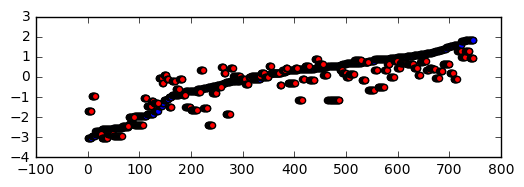

In [30]:
import matplotlib.pyplot as plt
idx_targets = dict((idx, tg) for idx, tg in zip(range(len(targets)), targets))
idx_outputs = dict((idx, tg) for idx, tg in zip(range(len(output)), output))
targets_idx = dict((v, k) for k, v in idx_targets.items())

sorted_targets = sorted(list(targets))
sorted_idx = [targets_idx[tg] for tg in sorted_targets]
sorted_outputs = [idx_outputs[idx] for idx in sorted_idx]
plt.figure()
plt.subplot(211)
plt.scatter(range(len(sorted_targets)), sorted_targets)
plt.scatter(range(len(sorted_outputs)), sorted_outputs, c='r')
plt.show()